In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.mixed_precision as mp
from datetime import datetime

from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Data inspection

About the data we know:

"In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder."

- We need to handle the NAN values that are filled with -1.
- Submissions are evaluated using the Normalized Gini Coefficient.
- Column name meanings:
-     - tags: ind, reg, car, calc -> same feature groups
      - bin: binary
      - cat: multicategory features

In [2]:
train_data = pd.read_csv("/kaggle/input/porto-seguro-safe-driver-prediction/train.csv")
test_data = pd.read_csv("/kaggle/input/porto-seguro-safe-driver-prediction/test.csv")

test_data_id = test_data['id'] # Keep id separately for submission
train_data.drop(['id'],axis=1,inplace=True)
test_data.drop(['id'],axis=1,inplace=True)
train_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
1,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
2,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
3,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Rename numerical cols by adding "_num"
num_cols = [col for col in train_data.columns if not (col.endswith('cat') | col.endswith('bin') | col.endswith('target'))]
train_data.rename(columns={col: col + "_num" for col in num_cols}, inplace=True)
test_data.rename(columns={col: col + "_num" for col in num_cols}, inplace=True)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01_num   595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03_num   595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14_num   595212 non-null  int64  
 15  ps_ind_15_num   595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_

In [5]:
train_data.describe()

,target,ps_ind_01_num,ps_ind_02_cat,ps_ind_03_num,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11_num,ps_calc_12_num,ps_calc_13_num,ps_calc_14_num,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Handle NANs

In [6]:
# Replace -1 with nans first
train_data = train_data.replace(-1, np.nan)
test_data = test_data.replace(-1, np.nan)

# Now lets see how many missing values we have
missing_data = train_data.isnull().sum().sort_values(ascending=False)
missing_percent = (train_data.isnull().sum()) / len(train_data)*100
missing_data = pd.concat([missing_data, missing_percent], axis=1, keys=["Total", "Percent"])

print(f"Amount of missing data:\n{missing_data[missing_data['Total']>0]}")

Amount of missing data:
                Total    Percent
ps_car_03_cat  411231  69.089837
ps_car_05_cat  266551  44.782531
ps_reg_03_num  107772  18.106490
ps_car_14_num   42620   7.160474
ps_car_07_cat   11489   1.930237
ps_ind_05_cat    5809   0.975955
ps_car_09_cat     569   0.095596
ps_ind_02_cat     216   0.036290
ps_car_01_cat     107   0.017977
ps_ind_04_cat      83   0.013945
ps_car_02_cat       5   0.000840
ps_car_11_num       5   0.000840
ps_car_12_num       1   0.000168


In [7]:
# Drop the cols with more than 20 percent missing data
cols_to_drop = list(missing_data.loc[missing_data['Percent']>20].index)
train_data.drop(columns=cols_to_drop, inplace=True)
test_data.drop(columns=cols_to_drop, inplace=True)

In [8]:
# Impute missing values
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

bin_cols = [col for col in train_data.columns if col.endswith('bin')]
cat_cols = [col for col in train_data.columns if col.endswith('cat')]
num_cols = [col for col in train_data.columns if col.endswith('num')]

train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])
test_data[num_cols] = num_imputer.transform(test_data[num_cols])
train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])
test_data[cat_cols] = cat_imputer.transform(test_data[cat_cols])
train_data[bin_cols] = np.round(cat_imputer.fit_transform(train_data[bin_cols]))
test_data[bin_cols] = np.round(cat_imputer.transform(test_data[bin_cols]))

In [9]:
train_data.isna().sum()

target            0
ps_ind_01_num     0
ps_ind_02_cat     0
ps_ind_03_num     0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14_num     0
ps_ind_15_num     0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01_num     0
ps_reg_02_num     0
ps_reg_03_num     0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_04_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11_num     0
ps_car_12_num     0
ps_car_13_num     0
ps_car_14_num     0
ps_car_15_num     0
ps_calc_01_num    0
ps_calc_02_num    0
ps_calc_03_num    0
ps_calc_04_num    0
ps_calc_05_num    0
ps_calc_06_num    0
ps_calc_07_num    0
ps_calc_08_num    0
ps_calc_09_num    0
ps_calc_10_num    0
ps_calc_11_num    0
ps_calc_12_num    0
ps_calc_13_num    0
ps_calc_14_num    0


## Reduce multicollinearity

In [10]:
# Define correlation thresholds
corr_thd = 0.7  # Feature to feature correlation
target_corr_thd = 0.05  # Correlation with target

# Identify highly correlated features
corr_matrix = train_data.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(col, row, abs(upper_tri.loc[row, col])) for col in upper_tri.columns for row in upper_tri.index if abs(upper_tri.loc[row, col]) > corr_thd]
print("High correlation pairs:")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

# Compare the pairs and choose the better predictor
target_corr = corr_matrix["target"].abs() # Abs correlation with target

features_to_drop = set()

for col1, col2, _ in high_corr_pairs:
    if target_corr[col1] > target_corr[col2]:
        features_to_drop.add(col2)
    else:
        features_to_drop.add(col1)

# Keep the stronger target correlation feature
train_data.drop(columns=features_to_drop, inplace=True)
test_data.drop(columns=features_to_drop, inplace=True)
print(f"Dropped features: {features_to_drop}")

High correlation pairs:
ps_ind_14_num - ps_ind_12_bin: 0.890
ps_reg_03_num - ps_reg_02_num: 0.728
Dropped features: {'ps_ind_14_num', 'ps_reg_03_num'}


In [11]:
# Filter out dropped features
num_cols = [col for col in num_cols if col not in features_to_drop]
print(f"Binary: {len(bin_cols)}, Multi: {len(cat_cols)}, Num: {len(num_cols)} Total should be: {len(train_data.columns)-1}")

Binary: 17, Multi: 12, Num: 24 Total should be: 53


## Scale and encode features

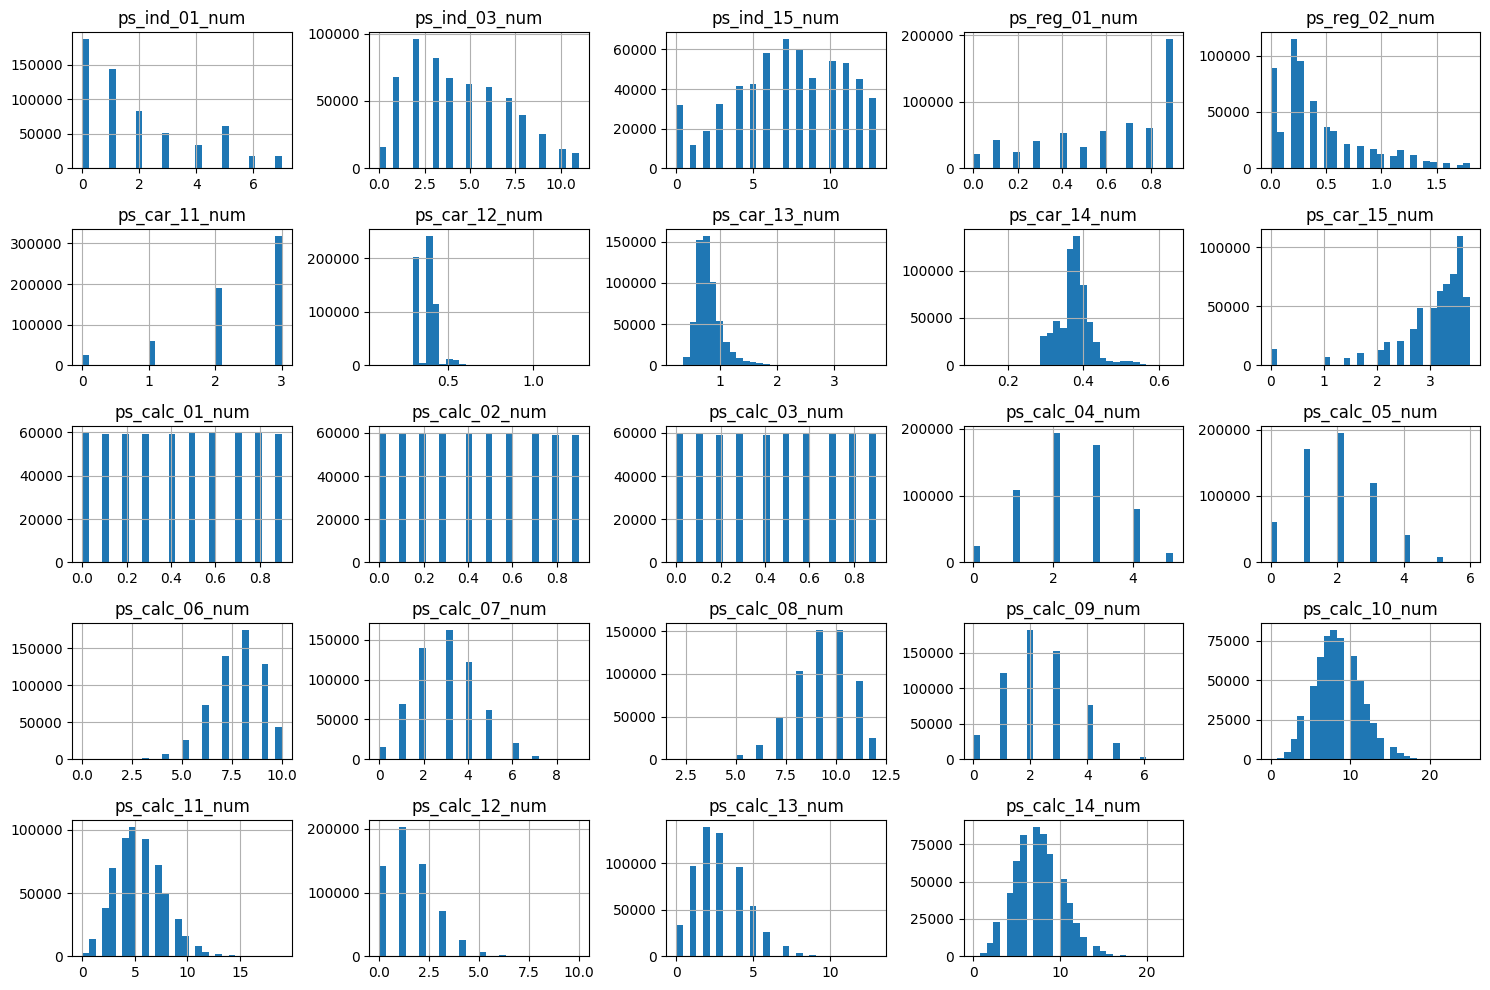

In [12]:
# Plot histograms for numerical features
train_data[num_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [13]:
# Checking num cols unique values to identify real numerical cols
for col in num_cols:
    if len(train_data[col].unique()) < 30:
        print(f"{col} has [{len(train_data[col].unique())}] [{train_data[col].dtype}]:\n{train_data[col].unique()}");print();
    else:
        print(f"{col} has [{len(train_data[col].unique())}] [{train_data[col].dtype}]:\n{train_data[col].unique()[:30]}\n...");print(); 

ps_ind_01_num has [8] [float64]:
[2. 1. 5. 0. 4. 3. 6. 7.]

ps_ind_03_num has [12] [float64]:
[ 5.  7.  9.  2.  0.  4.  3.  1. 11.  6.  8. 10.]

ps_ind_15_num has [14] [float64]:
[11.  3. 12.  8.  9.  6. 13.  4. 10.  5.  7.  2.  0.  1.]

ps_reg_01_num has [10] [float64]:
[0.7 0.8 0.  0.9 0.6 0.5 0.4 0.3 0.2 0.1]

ps_reg_02_num has [19] [float64]:
[0.2 0.4 0.  0.6 1.8 0.1 0.7 1.4 0.9 0.3 0.5 0.8 1.  1.3 1.6 1.5 1.2 1.1
 1.7]

ps_car_11_num has [4] [float64]:
[2. 3. 1. 0.]

ps_car_12_num has [183] [float64]:
[0.4        0.31622777 0.37416574 0.31606961 0.44598206 0.44698993
 0.4472136  0.54772256 0.31527766 0.42426407 0.52915026 0.39987498
 0.40841156 0.38729833 0.42355637 0.4237924  0.36055513 0.39749214
 0.51961524 0.41797129 0.48989795 0.42201896 0.31559468 0.44586994
 0.39862263 0.56568542 0.64807407 0.39974992 0.59160798 0.47958315]
...

ps_car_13_num has [70482] [float64]:
[0.88367892 0.61881652 0.64158572 0.54294879 0.5658315  0.87904907
 0.6396829  0.90057374 0.78064129 1.4581843

In [14]:
# Based on this we can see that most of these columns are categoricals.
# Therefore we need to scale them differently:
# - First I filter out the 'real' numericals and scale them with Standard scaler
# - Next I add the 'false' numericals to the categoricals
# - Then I am going to handle the categoricals in 2 ways:
#   - One-hot encode the features with 10+ categories
#   - Label encode the features with 10- categories

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

# Lists of feature groups
real_nums = [
    'ps_car_13_num', 'ps_car_14_num','ps_car_15_num',
    'ps_calc_01_num', 'ps_calc_02_num', 'ps_calc_03_num',
    'ps_reg_01_num', 'ps_reg_02_num', 'ps_car_12_num',
]
false_nums = [
    'ps_ind_01_num', 'ps_ind_03_num', 'ps_ind_15_num',
    'ps_car_11_num', 'ps_calc_04_num', 'ps_calc_05_num',
    'ps_calc_06_num', 'ps_calc_07_num', 'ps_calc_08_num',
    'ps_calc_09_num', 'ps_calc_10_num', 'ps_calc_11_num',
    'ps_calc_12_num', 'ps_calc_13_num', 'ps_calc_14_num'
]

# There is a 'ps_car_11_num' and a 'ps_car_11_cat' among the features so I will rename it to 'ps_car_16_num'
# to avoid duplicates
train_data.rename(columns={'ps_car_11_num':'ps_car_16_num'}, inplace=True)
test_data.rename(columns={'ps_car_11_num':'ps_car_16_num'}, inplace=True)
false_nums[3] = 'ps_car_16_num'

# Rename the false num cols and recollect them
train_data.rename(columns={col: col.replace("_num","_cat") for col in false_nums}, inplace=True)
test_data.rename(columns={col: col.replace("_num","_cat") for col in false_nums}, inplace=True)
cat_cols = [col for col in train_data.columns if col.endswith('cat')]
num_cols = [col for col in train_data.columns if col.endswith('num')]

# Convert the flase nums to integer (labelencoder has problem with float)
for col in cat_cols:
    train_data[col] = train_data[col].astype('int64')
    test_data[col] = test_data[col].astype('int64')

# CHECK DATA
# for col in cat_cols:
#     print(f"Column: {col}\nDtype:\n{type(train_data[col])}\nUnique Values: {train_data[col].nunique()}");print();

# # Handle categoricals differently
ohe_cols = [col for col in cat_cols if train_data[col].nunique() < 10]
le_cols = [col for col in cat_cols if train_data[col].nunique() >= 10]
train_data.rename(columns={col: col.replace("_cat","_ohe") for col in ohe_cols}, inplace=True)
test_data.rename(columns={col: col.replace("_cat","_ohe") for col in ohe_cols}, inplace=True)
cat_cols = [col for col in train_data.columns if col.endswith('cat')]
ohe_cols = [col for col in train_data.columns if col.endswith('ohe')]

# Standard scale continuous numerical features
scaler_std = StandardScaler()
train_data[num_cols] = scaler_std.fit_transform(train_data[num_cols])
test_data[num_cols] = scaler_std.transform(test_data[num_cols])

# Label encode 10+ categorical features
le_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)  # Assign -1 to unknown values
train_data[le_cols] = le_encoder.fit_transform(train_data[le_cols])
test_data[le_cols] = le_encoder.transform(test_data[le_cols])

# One-hot encode the rest
train_data = pd.get_dummies(train_data, columns=ohe_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=ohe_cols, drop_first=True)
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

# Recollect ohe cols since pandas renames them with postfix
ohe_cols = [col for col in train_data.columns if 'ohe' in col]

print(f"Binary: {len(bin_cols)}\nMulti: {len(cat_cols)} (ohe:{len(ohe_cols)}, le:{len(le_cols)})\nNum: {len(num_cols)}\nTotal should be: {len(train_data.columns)-1}")

Binary: 17
Multi: 14 (ohe:47, le:14)
Num: 9
Total should be: 87


In [15]:
# Both with target
len(train_data.columns), len(test_data.columns) 

(88, 88)

## Remove low variance features

In [16]:
print(f"Number of cols before (train): {len(train_data.columns)}")
print(f"Number of cols before (test): {len(test_data.columns)}");print()

threshold = 0.01
variances = train_data.drop(['target'],axis=1).var()
sorted_variances = variances.sort_values() # sorting them in asc
low_variance_features = variances[variances < threshold].index.tolist() # threshold low var features as <1%
train_data = train_data.drop(columns=low_variance_features) # drop low var features
test_data = test_data.drop(columns=low_variance_features) # drop low var features

print(f"Number of cols after (train): {len(train_data.columns)}")
print(f"Number of cols after (test): {len(test_data.columns)}")

Number of cols before (train): 88
Number of cols before (test): 88

Number of cols after (train): 76
Number of cols after (test): 76


In [17]:
# Update cols
bin_cols = [col for col in train_data.columns if 'bin' in col]
num_cols = [col for col in train_data.columns if 'num' in col]
cat_cols = [col for col in train_data.columns if ('cat' in col) | ('ohe' in col)]
print(f"Binary: {len(bin_cols)}, Multi: {len(cat_cols)}, Num: {len(num_cols)}")

Binary: 13, Multi: 53, Num: 9


## Feature selection

- PCA
- Mutual Information


In [18]:
# from sklearn.feature_selection import mutual_info_classif

# # Extract the target and features again
# target = train_data['target']

# # Select binary and multi category features only
# features = train_data.copy()[cat_cols + bin_cols]

# # Compute the mutual information for feature selection
# mi_scores = mutual_info_classif(features, target)

# # Create a DataFrame to view MI scores
# mi_scores_df = pd.DataFrame({
#     'Feature': features.columns,
#     'MI Score': mi_scores
# })

# # Select features by MI score
# sel_amount = 20
# mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)
# print(f"Top features based on Mutual Information:\n{mi_scores_df.head(sel_amount)}")
# mi_selection = mi_scores_df.head(sel_amount)['Feature'].tolist()

(Took too much time and didnt provided good results)

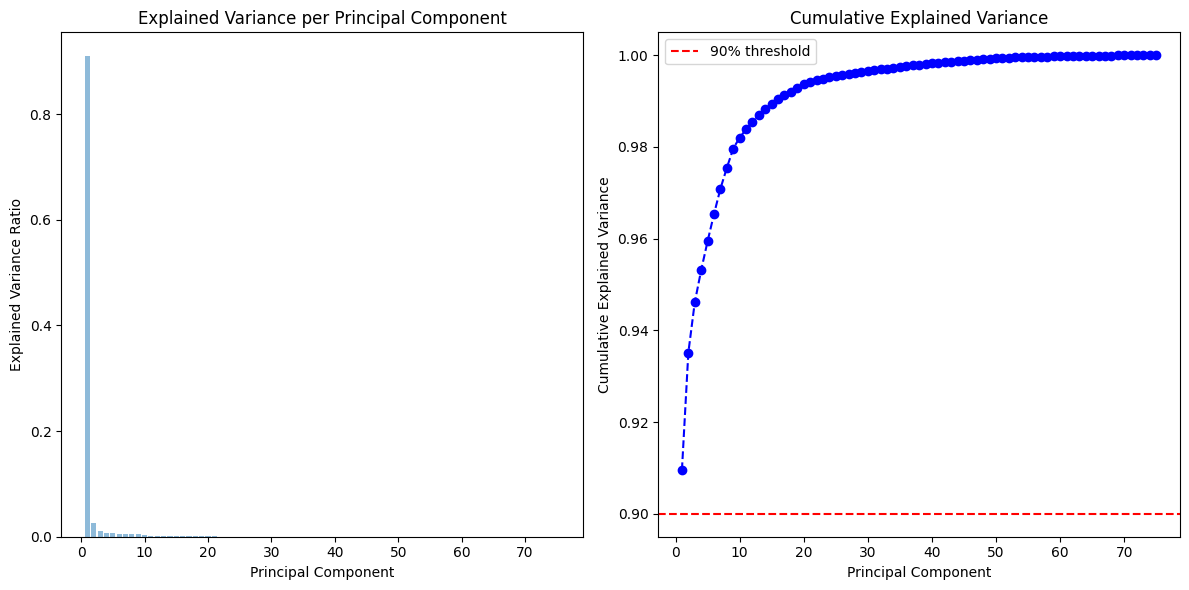


Number of components to retain 95% variance: 4


Variance ratio explained by principal components:
PC1: 0.9095 (90.95%)
PC2: 0.0256 (2.56%)
PC3: 0.0109 (1.09%)
PC4: 0.0070 (0.70%)


In [19]:
# PCA analysis
from sklearn.decomposition import PCA

# 1. Drop target from data to explore
features_reduced = train_data.drop(columns=['target'], axis=1)

# 2. Apply PCA with all components, also plotting cumulative and explained variance
# Fit and transform the data with PCA
pca = PCA(n_components=None)  # Keeping all components to analyze explained variance
pca.fit(features_reduced)
pca_tr = pca.transform(features_reduced)

# Explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting explained variance and cumulative variance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance per Principal Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Reduce n_components to determine how many are the most descriptive ones (95% of variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components to retain 95% variance: {n_components}\n")

# 4. Apply PCA with selected number of components
pca = PCA(n_components=n_components)
features_pca_reduced = pca.fit_transform(features_reduced)

# 5. Get the explained variance ratio for each PC
explained_variance_ratio = pca.explained_variance_ratio_
print("\nVariance ratio explained by principal components:")
for i in range(n_components):
    pc = f'PC{i+1}'
    variance_ratio = explained_variance_ratio[i]
    print(f"{pc}: {variance_ratio:.4f} ({variance_ratio * 100:.2f}%)")


In [20]:
# Create df from pca results
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                            index=features_reduced.columns)

In [21]:
# ---- Select features from PCA result ------
threshold = 0.03 # 0.03-0.06
pca_selected_features = []

for i in range(pca.n_components_):
    pc = f'PC{i+1}'
    component_loadings = loadings[pc].abs() # take a pc with absolute values
    th_applied_features = component_loadings[component_loadings > threshold].index.tolist() # apply threshold
    pca_selected_features.extend(th_applied_features)

# Remove duplicates
pca_selected_features = list(set(pca_selected_features))
# print(f'PCA selected features:\n {pca_selected_features}\n{len(pca_selected_features)}')

# If there are more than max_n selected features, then rank them by taking the cummulative weights accross all PCS
max_n = 20
if len(pca_selected_features) > max_n:
    cw_loadings = loadings.loc[pca_selected_features].abs().sum(axis=1) # cummulate weights for these features
    pca_final_selection = cw_loadings.sort_values(ascending=False).head(max_n).index.to_list() # rank them
else:
    pca_final_selection = pca_selected_features

print(f'PCA final selection:\n {pca_final_selection}\n{len(pca_final_selection)}')

PCA final selection:
 ['ps_ind_16_bin', 'ps_ind_03_cat', 'ps_car_13_num', 'ps_ind_15_cat', 'ps_ind_18_bin', 'ps_calc_10_cat', 'ps_car_01_cat', 'ps_car_11_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_12_num', 'ps_car_14_num']
12


### Handle class imbalance

In [22]:
# Checking out the targets distribution

target_count = train_data.target.value_counts()
print(f'Class 0: {target_count[0]} - {target_count[0]/len(train_data)*100:.2f}%')
print(f'Class 1: {target_count[1]} - {target_count[1]/len(train_data)*100:.2f}%')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')

Class 0: 573518 - 96.36%
Class 1: 21694 - 3.64%
Proportion: 26.44 : 1


We can observe how imbalanced the dataset is. We certainly need some fix with resampling, but first we need to split up the dataset to train and validation sets, otherwise we would be using synthetic data on the validation set.

In [23]:
from sklearn.model_selection import train_test_split

# Take a subset from train_data
# subset = train_data.sample(n=200000, random_state=seed)
subset = train_data.copy() # all 595212 data points

# Feature selection
# (Tried both PCA and MI selection, but in the end I got better results on the 'whole' feature set)
# subset = subset[pca_final_selection + ['target']]

# Split up dataset
X, y = subset.drop(['target'], axis=1), subset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Value counts - Train")
print(y_train.value_counts())
print("Value counts - Test")
print(y_test.value_counts())

y0_train, y1_train = y_train.value_counts()[0], y_train.value_counts()[1]
y0_test, y1_test = y_test.value_counts()[0], y_test.value_counts()[1]

print("Compare targets:")
print(f"- minority for train: {y1_train/len(y_train)*100:.2f}% ({y1_train})")
print(f"- minority for test: {y1_test/len(y_test)*100:.2f}% ({y1_test})")

Value counts - Train
target
0    458860
1     17309
Name: count, dtype: int64
Value counts - Test
target
0    114658
1      4385
Name: count, dtype: int64
Compare targets:
- minority for train: 3.64% (17309)
- minority for test: 3.68% (4385)


In [24]:
# Test different resample techniques:
# 1. Random Over Sampling
# 2. Random Under Sampling
# 3. Random Under Sampling (keeping some more from majority class)
# 4. SMOTE

from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

rus_strat = {0: y1_train*4, 1: y1_train,} # take 4:1 ratio from classes (just reducing imbalance)

ros = RandomOverSampler(random_state=seed)
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)
rus_with_ratio = RandomUnderSampler(sampling_strategy=rus_strat, random_state=seed)
smote = SMOTE(random_state=seed)
# svms = SVMSMOTE(sampling_strategy='minority', k_neighbors=3, random_state=seed) # Takes too much time for SVM

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_rusr, y_train_rusr = rus_with_ratio.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# X_train_svms, y_train_svms = svms.fit_resample(X_train, y_train)

In [25]:
print("Random Over Sampler:\n",y_train_ros.value_counts())
print("Random Under Sampler:\n",y_train_rus.value_counts())
print("Random Under Sampler with ratio:\n",y_train_rusr.value_counts())
print("SMOTE:\n",y_train_smote.value_counts())
# print("SVM SMOTE:\n",y_train_svms.value_counts())

Random Over Sampler:
 target
0    458860
1    458860
Name: count, dtype: int64
Random Under Sampler:
 target
0    17309
1    17309
Name: count, dtype: int64
Random Under Sampler with ratio:
 target
0    69236
1    17309
Name: count, dtype: int64
SMOTE:
 target
0    458860
1    458860
Name: count, dtype: int64


In [26]:
# Test all resampling with Decesion tree to choose the best one
from sklearn.tree import DecisionTreeClassifier

def test_resampling(X_train, y_train, X_test, y_test, name):
    dt = DecisionTreeClassifier(
        min_samples_split=5, 
        min_samples_leaf=16, 
        max_depth=10,
        criterion='entropy',
    )
    dt.fit(X_train, y_train)
    preds = dt.predict(X_test)
    probs = dt.predict_proba(X_test)[:, 1]
    
    test_bacc = balanced_accuracy_score(y_test, preds)
    test_auc = roc_auc_score(y_test, probs)
    cm = confusion_matrix(y_test, preds)

    print(f"--- {name} ---")
    print(f"Test balanced accuracy: {test_bacc:.3f}")
    print(f"Test AUC score: {test_auc:.3f}")
    print("Confusion matrix:\n",cm)

test_resampling(X_train_ros, y_train_ros, X_test, y_test, name='ROS')
test_resampling(X_train_rus, y_train_rus, X_test, y_test, name='RUS')
test_resampling(X_train_rusr, y_train_rusr, X_test, y_test, name='RUSR')
test_resampling(X_train_smote, y_train_smote, X_test, y_test, name='SMOTE')
# test_resampling(X_train_svms, y_train_svms, X_test, y_test, name='SVM SMOTE')

--- ROS ---
Test balanced accuracy: 0.564
Test AUC score: 0.587
Confusion matrix:
 [[76697 37961]
 [ 2370  2015]]
--- RUS ---
Test balanced accuracy: 0.567
Test AUC score: 0.592
Confusion matrix:
 [[76505 38153]
 [ 2337  2048]]
--- RUSR ---
Test balanced accuracy: 0.512
Test AUC score: 0.592
Confusion matrix:
 [[112756   1902]
 [  4209    176]]
--- SMOTE ---
Test balanced accuracy: 0.500
Test AUC score: 0.530
Confusion matrix:
 [[110018   4640]
 [  4205    180]]


Since RUS and RUSR gave similar AUC score, I will use RUSR because it has more records.

In [27]:
X_train = X_train_rusr.copy()
y_train = y_train_rusr.copy()
X_train.shape, y_train.shape

((86545, 75), (86545,))

## Modelling
- Logistic Regression
- Decesion Tree
- Random forest
- XGBoost
- LightGBM
- Neural Network

In [28]:
# Define parameter grids
param_grids = {
    'LR': {
        'penalty': ['l1', 'l2'],  # Regularization method
        'solver': ['liblinear', 'saga'],  # 'saga' works with both 'l1' and 'l2' and scales well with large datasets
        'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse regularization strength
        'max_iter': [500],
    },
    'DT': {
        'criterion': ['gini','entropy'],
        'max_depth': [5, 10, 15],  # Tree depth
        'min_samples_split': [2, 5, 8, 16],  # Min samples to split a node
        'min_samples_leaf': [2, 5, 8, 16],  # Min samples
    },
    'RF': {
        'n_estimators': [100, 200, 300],  # Number of trees
        'max_depth': [5, 10, 15],  # Tree depth
        'min_samples_split': [2, 5],  # Min samples to split a node
        'min_samples_leaf': [2, 5, 10],  # Min samples in a leaf
        'max_features': ['sqrt', 'log2'],  # Feature selection method
        'class_weight': ['balanced'],  # Handling imbalance
    },
    'XGB': {
        'n_estimators': [100, 200, 300, 400],  # Number of boosting rounds
        'learning_rate': [0.01, 0.1],  # Step size shrinkage
        'max_depth': [5, 10, 15],  # Tree depth
        'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (higher = less overfitting)
        'max_delta_step': [0, 1, 5, 8], # Might help when dataset is highly imbalanced
        'reg_alpha': [0.0, 0.1, 0.5, 1.0],  # L1 regularization
        'reg_lambda': [0.0, 0.1, 0.5, 1.0],  # L2 regularization
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'device': ['cuda'],
        # 'scale_pos_weight': [26]  # Handling imbalance
    },
    'LGBM': {
        'n_estimators': [100, 200, 300, 400],  # Number of boosting rounds
        'learning_rate': [0.01, 0.1],  # Step size shrinkage
        'max_depth': [5, 10, 15],  # Limits tree depth
        'num_leaves': [5, 15, 20, 30],  # Number of leaves per tree
        'min_child_samples': [5, 10, 20],  # Minimum number of data points in a leaf
        'reg_alpha': [0.0, 0.1, 0.5, 1.0],  # L1 regularization
        'reg_lambda': [0.0, 0.1, 0.5, 1.0],  # L2 regularization
        'objective': ['binary'], # Learning task
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'class_weight': ['balanced'],  # Handling imbalance
    },
}

# Use Stratified K-fold CV to preserve the class ratios
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
n_iter = 5

# Create a function to run GridSearchCV for each classifier
def run_random_search(clf, param_grid, X_train, y_train, n_iter=5, cv=5):
    random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=n_iter, cv=cv, n_jobs=-1, scoring='roc_auc', random_state=seed)    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

# Logistic Regression
start = datetime.now()
clf_lr = LogisticRegression()
best_clf_lr, best_params_lr, best_score_lr = run_random_search(clf_lr, param_grids['LR'], X_train, y_train, n_iter=n_iter, cv=skfold)
end = datetime.now()-start
print("Logistic Regression finished training.")
print(f" - time spent (hh:mm:ss:ms): {end}")

# Decesion Tree
start = datetime.now()
clf_dt = DecisionTreeClassifier()
best_clf_dt, best_params_dt, best_score_dt = run_random_search(clf_dt, param_grids['DT'], X_train, y_train, n_iter=n_iter, cv=skfold)
end = datetime.now()-start
print("Decesion Tree finished training.")
print(f" - time spent (hh:mm:ss:ms): {end}")

# Random Forest
start = datetime.now()
clf_rf = RandomForestClassifier()
best_clf_rf, best_params_rf, best_score_rf = run_random_search(clf_rf, param_grids['RF'], X_train, y_train, n_iter=n_iter, cv=skfold)
end = datetime.now()-start
print("Random Forest finished training.")
print(f" - time spent (hh:mm:ss:ms): {end}")

# XGBoost
start = datetime.now()
clf_xgb = XGBClassifier()
best_clf_xgb, best_params_xgb, best_score_xgb = run_random_search(clf_xgb, param_grids['XGB'], X_train, y_train, n_iter=n_iter, cv=skfold)
end = datetime.now()-start
print("XGBoost finished training.")
print(f" - time spent (hh:mm:ss:ms): {end}")

# LightGBM
start = datetime.now()
clf_lgbm = LGBMClassifier()
best_clf_lgbm, best_params_lgbm, best_score_lgbm = run_random_search(clf_lgbm, param_grids['LGBM'], X_train, y_train, n_iter=n_iter, cv=skfold)
end = datetime.now()-start
print("LightGBM finished training.")
print(f" - time spent (hh:mm:ss:ms): {end}")
print();

# Collect metric result
metric_dict = {
    "BACC": {},
    "AUC": {},
}

# Evaluate and print results
def print_results(best_clf, best_params, X_test, y_test, classifier_name):
    
    y_pred = best_clf.predict(X_test)
    y_prob = best_clf.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)    
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    clf_rep = classification_report(y_test, y_pred)
    metric_dict["BACC"][classifier_name] = (best_clf, balanced_accuracy)
    metric_dict["AUC"][classifier_name] = (best_clf, roc_auc)

    print(f"{classifier_name} - Best Parameters: {best_params}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.3f}")
    print(f"ROC AUC Score: {roc_auc:.3f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{clf_rep}")
    print("*"*50)
    return y_pred, y_prob

# Print results for all classifiers
lr_preds, lr_probs = print_results(best_clf_lr, best_params_lr, X_test, y_test, "Logistic Regression")
dt_preds, df_probs = print_results(best_clf_dt, best_params_dt, X_test, y_test, "Decision Tree")
rf_preds, rf_probs = print_results(best_clf_rf, best_params_rf, X_test, y_test, "Random Forest")
xgb_preds, xgb_probs = print_results(best_clf_xgb, best_params_xgb, X_test, y_test, "XGBoost")
lgbm_preds, lgbm_probs = print_results(best_clf_lgbm, best_params_lgbm, X_test, y_test, "LightGBM")


Logistic Regression finished training.
 - time spent (hh:mm:ss:ms): 0:02:39.031100
Decesion Tree finished training.
 - time spent (hh:mm:ss:ms): 0:00:11.622248
Random Forest finished training.
 - time spent (hh:mm:ss:ms): 0:03:43.015389
XGBoost finished training.
 - time spent (hh:mm:ss:ms): 0:01:05.001386
[LightGBM] [Info] Number of positive: 17309, number of negative: 69236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 86545, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM finished training.
 - time spent (hh:mm:ss:ms): 0:00:48.902798

Logistic Regression - Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 0.1}
Accuracy:

### Neural network model

In [29]:
# Tensorflow manages GPU allocation automatically
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Using GPU:", tf.test.is_gpu_available())
print("GPU Device:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
Using GPU: True
GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
# Target ratio
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
print(neg/pos)

4.0


In [31]:
# Enable mixed precision training
mp.set_global_policy('mixed_float16')

# Set hyperparameters
EPS = 50
BS = 256
L_RATE = 5e-3
INPUT_SHAPE = (X_train.shape[1],) # num of features
WEIGHT_DECAY = 1e-3
MONITOR = 'val_auc'
ALPHA = 1 / (1+(neg/pos))
GAMMA = 3.0 # higher for more severe imbalance

# Custom Focal Loss to handle imbalance
def focal_loss(alpha=0.25, gamma=2.0):
    """ alpha: Adjusts the weight of minority vs. majority classes.
                ( 1 / (1 + imbalance ratio) )
        gamma: Reduces loss for well-classified examples and focuses on hard ones.
    """
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        loss = alpha * (1 - p_t) ** gamma * bce
        return tf.reduce_mean(loss)
    return loss

nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=INPUT_SHAPE),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(), # prevents dying neurons
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(0.3),

    # tf.keras.layers.Dense(32),
    # tf.keras.layers.BatchNormalization(),
    # # tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.ReLU(),
    # # tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation="sigmoid")  
])

LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=2)
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=6, restore_best_weights=True)
MC = tf.keras.callbacks.ModelCheckpoint("./best_nn_model.keras", save_best_only=True)

METRICS = [
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

nn_model.compile(
    loss = focal_loss(alpha=ALPHA, gamma=GAMMA),
    # loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.AdamW(learning_rate=L_RATE, weight_decay=WEIGHT_DECAY),
    metrics = METRICS,
)

nn_history = nn_model.fit(
    X_train,
    y_train,
    epochs=EPS,
    batch_size=BS,
    validation_data=(X_test, y_test),
    callbacks=[LR,ES,MC],
    # class_weight={0:1, 1:26},
)

Epoch 1/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - Brier score: 0.1697 - accuracy: 0.7940 - auc: 0.5595 - loss: 0.0102 - prc: 0.2365 - precision: 0.2305 - recall: 0.0109 - val_Brier score: 0.0959 - val_accuracy: 0.9630 - val_auc: 0.6017 - val_loss: 0.0027 - val_prc: 0.0590 - val_precision: 0.3171 - val_recall: 0.0030 - learning_rate: 0.0050
Epoch 2/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Brier score: 0.1651 - accuracy: 0.7993 - auc: 0.6038 - loss: 0.0091 - prc: 0.2720 - precision: 0.3567 - recall: 0.0039 - val_Brier score: 0.0964 - val_accuracy: 0.9629 - val_auc: 0.6108 - val_loss: 0.0027 - val_prc: 0.0614 - val_precision: 0.2364 - val_recall: 0.0030 - learning_rate: 0.0050
Epoch 3/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Brier score: 0.1641 - accuracy: 0.7996 - auc: 0.6145 - loss: 0.0090 - prc: 0.2816 - precision: 0.4261 - recall: 0.0047 - val_Brier score: 0.0963 - val_accuracy: 0.9631 - val_auc: 0.6166 - val_loss: 0.0027 - val_prc: 0.0616 - val_precision: 0.3200 - val

<Axes: >

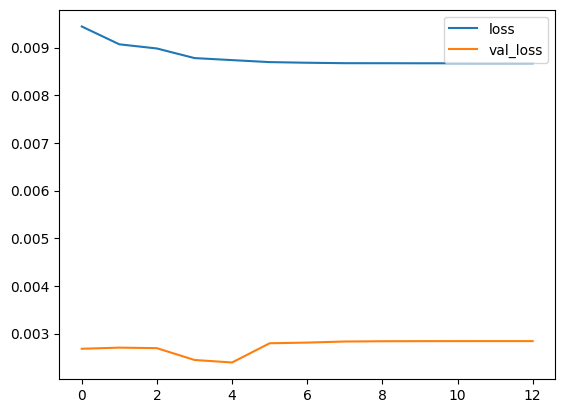

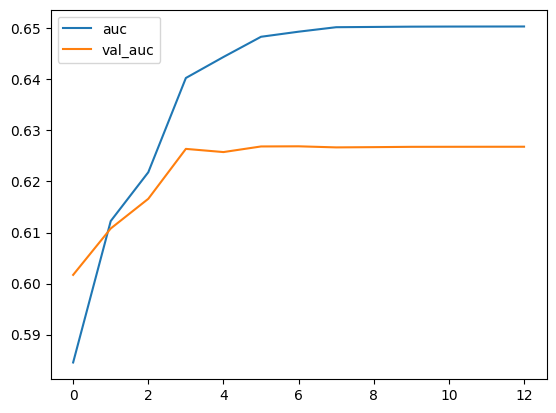

In [32]:
pd.DataFrame(nn_history.history)[["loss","val_loss"]].plot()
pd.DataFrame(nn_history.history)[["auc","val_auc"]].plot()

In [33]:
# Evaluate on validation set
nn_probs = nn_model.predict(X_test)
nn_preds = tf.round(nn_probs)
nn_bacc = balanced_accuracy_score(y_test, nn_preds)
nn_auc = roc_auc_score(y_test, nn_probs)
metric_dict["BACC"]["NN"] = (nn_model, nn_bacc)
metric_dict["AUC"]["NN"] = (nn_model, nn_auc)
print(f"NN balanced accuracy: {nn_bacc}")
print(f"NN roc auc score: {nn_auc}")

nn_cm = confusion_matrix(y_true=y_test, y_pred=nn_preds)
nn_clf_rep = classification_report(y_true=y_test, y_pred=nn_preds)
print("Confusion matrix:\n",nn_cm)
print("Classification report:\n",nn_clf_rep)

3721/3721 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
NN balanced accuracy: 0.5022918009919063
NN roc auc score: 0.6268677651705783
Confusion matrix:
 [[114556    102]
 [  4361     24]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    114658
           1       0.19      0.01      0.01      4385

    accuracy                           0.96    119043
   macro avg       0.58      0.50      0.50    119043
weighted avg       0.93      0.96      0.95    119043



In [34]:
test_data.shape, X_test.shape

((892816, 76), (119043, 75))

In [35]:
# Select best model
chosen_model = ''
best = 0
balanced_acc_th = 0.56

for k,v in metric_dict['AUC'].items():
    auc_score = v[1]
    bacc_score = metric_dict["BACC"][k][1]
    print(f'{k} - {auc_score:.3f} (AUC) - {bacc_score:.3f} (BACC)')
    if bacc_score > balanced_acc_th:
        if auc_score > best:
            best = auc_score
            chosen_model = k

if chosen_model:
    model_to_use = metric_dict['AUC'][chosen_model][0]
    print(f"\nChosen model: {chosen_model}")
else:
    model_to_use = metric_dict['AUC']['NN'][0]
    print("\nChosen model is NN (no model met the BACC th.).")

Logistic Regression - 0.625 (AUC) - 0.504 (BACC)
Decision Tree - 0.592 (AUC) - 0.512 (BACC)
Random Forest - 0.625 (AUC) - 0.588 (BACC)
XGBoost - 0.638 (AUC) - 0.501 (BACC)
LightGBM - 0.634 (AUC) - 0.597 (BACC)
NN - 0.627 (AUC) - 0.502 (BACC)

Chosen model: LightGBM


In [36]:
# Predict on test dataset
if chosen_model == 'NN':
    test_pred = model_to_use.predict(test_data.drop('target', axis=1))
else:
    test_pred = model_to_use.predict_proba(test_data.drop('target', axis=1))[:, 1]

submission = pd.concat([test_data_id, pd.DataFrame(test_pred, columns=['target'])], axis=1)
submission.head()

,id,target
0,0,0.430127
1,1,0.424992
2,2,0.468308
3,3,0.336998
4,4,0.496922


In [37]:
submission.to_csv('submission.csv', index=False)